In [1]:
import pandas as pd
from datetime import datetime, timedelta

import math

import json as json
from pandas.io.json import json_normalize

import numpy as np
import os
import scipy.optimize as sco

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
array_dataframe = []
dados = pd.DataFrame([])
scoins = []

folder_candle = 'Operacoes'

for folder in os.scandir(folder_candle):
    scoins.append(folder.name)
    for entry in os.scandir(folder):
        if entry.is_file():
            coin_symbol = (os.path.splitext(entry.name)[0])        
            with open(entry.path) as d:            
                coin_hist = json.load(d);
            df = json_normalize(coin_hist);
            
            if not df.empty:
            
                df['coin'] = folder.name
                df['amount'] = pd.to_numeric(df['amount'].replace('.',','))
                df['rate'] = pd.to_numeric(df['rate'].replace('.',','))
                df['total'] = pd.to_numeric(df['total'].replace('.',','))
                df['date'] = pd.to_datetime(df['date'])            
                df['day'] = pd.to_datetime(df['date'])
                #df['day'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.date
                
                array_dataframe.append(df)       
            else:
                print(entry.path)

dados = pd.concat(array_dataframe)

dados = dados.replace([np.inf, -np.inf], np.nan)
dados = dados.fillna(0)

dados.set_index('date', inplace=True)
dados.index = pd.to_datetime(dados.index)

dados.head()

Operacoes/USDT_BTC/2018-11.json
Operacoes/USDT_BTC/2018-12.json
Operacoes/USDT_ETH/2018-11.json
Operacoes/USDT_ETH/2018-12.json
Operacoes/USDT_LTC/2018-11.json
Operacoes/USDT_LTC/2018-12.json
Operacoes/USDT_ZEC/2018-11.json
Operacoes/USDT_ZEC/2018-12.json


,amount,globalTradeID,rate,total,tradeID,type,coin,day
date,,,,,,,,
2016-08-31 02:59:00,0.020843,51782713,577.106338,12.028627,687777,sell,USDT_BTC,2016-08-31 02:59:00
2016-08-31 02:58:46,0.020843,51782684,577.839987,12.043919,687776,buy,USDT_BTC,2016-08-31 02:58:46
2016-08-31 02:58:31,0.020843,51782678,577.106338,12.028627,687775,sell,USDT_BTC,2016-08-31 02:58:31
2016-08-31 02:58:18,0.020843,51782660,577.839988,12.043919,687774,buy,USDT_BTC,2016-08-31 02:58:18
2016-08-31 02:58:05,0.020843,51782633,577.106338,12.028627,687773,sell,USDT_BTC,2016-08-31 02:58:05


In [3]:
#Calcula a primeira data e a primeira janela de 24h

#data_inicial = dados.index.min()
data_inicial = pd.to_datetime('2015-08-01')
print(data_inicial)

#Calcula data final da primeira janela
data_final = data_inicial + timedelta(days=1)
print(data_final)

#Filtro para a janela
#mask_janela = (dados.index > data_inicial) & (dados.index <= data_final)

#Moeda base
moeda_base = 'USDT_BTC'

#Quantidade de ordens a serem avaliadas no head do book
qtd_relevante_head_book = 0.05 #5%
stop_inicial = 0.10 #10%

operacoes = []
minimo_analise = 5

id_operacoes = 0

2015-08-01 00:00:00
2015-08-02 00:00:00


In [4]:
def obtem_janela(dt_inicial, dt_final):
    return dados.loc[(dados.index > dt_inicial) & (dados.index <= dt_final)].sort_index(ascending=False)    

In [5]:
janela = obtem_janela(data_inicial,data_final)
janela.head(10)

,amount,globalTradeID,rate,total,tradeID,type,coin,day
date,,,,,,,,
2015-08-01 17:48:05,0.010000,9240823,279.845023,2.798450,19626,sell,USDT_BTC,2015-08-01 17:48:05
2015-08-01 17:43:27,0.000107,9240809,283.000000,0.030301,19625,buy,USDT_BTC,2015-08-01 17:43:27
2015-08-01 17:43:27,0.012905,9240808,279.850000,3.611372,19624,buy,USDT_BTC,2015-08-01 17:43:27
2015-08-01 17:38:59,0.224556,9240278,279.665000,62.800543,19623,buy,USDT_BTC,2015-08-01 17:38:59
2015-08-01 17:37:52,0.172513,9240246,275.724508,47.566018,19622,sell,USDT_BTC,2015-08-01 17:37:52
2015-08-01 17:37:49,0.360932,9240215,275.724508,99.517826,19621,sell,USDT_BTC,2015-08-01 17:37:49
2015-08-01 17:37:49,0.018569,9240214,278.000000,5.162249,19620,sell,USDT_BTC,2015-08-01 17:37:49
2015-08-01 17:37:49,0.000352,9240213,279.793314,0.098417,19619,sell,USDT_BTC,2015-08-01 17:37:49
2015-08-01 17:37:49,0.010130,9240212,279.793314,2.834320,19618,sell,USDT_BTC,2015-08-01 17:37:49


In [6]:
def calcula_qtd_relevante(dt):
    relevante = dt.coin.count() * qtd_relevante_head_book
    
    if relevante < minimo_analise:
        return minimo_analise
    
    return math.ceil(relevante)

def gera_id_operacao():
    global id_operacoes 
    id_operacoes = id_operacoes + 1
    return id_operacoes;

In [7]:
def avalia_moeda_base(dt):
    coin_result = dt[dt.coin == moeda_base]
    relevante = calcula_qtd_relevante(coin_result)
    
    if not coin_result.empty  :
        dt_sell = coin_result[coin_result.type == 'sell']
        dt_buy  = coin_result[coin_result.type == 'buy']
    
        #Verifica se a moeda base está em queda (sell > buy)
        if dt_sell.amount.sum() > dt_buy.amount.sum() :
            return True
    
    return False


def avalia_compra(dt):
    
    ## Verifica se a moeda base está no momento de compra
    if avalia_moeda_base(dt):
        
        for c in dt.coin.unique():
            coin_result = dt[dt.coin == c]
            
            relevante = calcula_qtd_relevante(coin_result)            
            
            coin_result = coin_result.head(relevante)
            
            if not coin_result.empty  :
                dt_sell = coin_result[coin_result.type == 'sell']
                dt_buy  = coin_result[coin_result.type == 'buy']
    
                #Verifica se a moeda base está em queda (sell > buy)
                if dt_buy.amount.sum() > dt_sell.amount.sum():
                    return True
    
    return False

In [8]:
def define_stop(dt):
    #print('Rate: '+ str(dt.rate))
    #print('10% Rate: '+ str((dt.rate * stop_inicial)))
    return dt.rate + (dt.rate * stop_inicial)

def simula_compra(dt):
    for c in dt[dt.coin != moeda_base].coin.unique() :        
        dt_moeda = dt[dt.coin == c]
        operacao_compra = dt[dt.coin == c].max()
        operacao_compra['id_operacao'] = gera_id_operacao()
        operacao_compra.type = 'buy'
        operacao_compra['closed'] = False
        operacao_compra['stop_update'] = 0
        operacao_compra['stop'] = define_stop(operacao_compra)
        operacoes.append(operacao_compra)

In [9]:
def simula_venda(book_sell, operacao_buy):        
    operacao_venda = book_sell[book_sell.coin == operacao_buy.coin].max()
    
    operacao_venda.type = 'sell'
    operacao_venda['id_operacao'] = operacao_buy.id_operacao
    operacao_buy['closed'] = True
    operacao_venda['closed'] = True
    operacoes.append(operacao_venda)
    
def estrategia(book):
    if not pd.DataFrame(operacoes).empty:
        
        for operacao_buy in operacoes:
            if (operacao_buy.type == 'buy') & (not operacao_buy.closed):
                coin_result = book[book.coin == operacao_buy.coin]               
                
                if not coin_result.empty  :
                    dt_buy = coin_result[coin_result.type == 'buy']
                    dt_buy = dt_buy[dt_buy.day > operacao_buy.day]
                    
                    relevante = calcula_qtd_relevante(dt_buy)
                    
                    dt_buy = dt_buy.head(relevante)
    
                    #Verifica se a moeda base está em queda (sell > buy)
                    if dt_buy.rate.max() <= operacao_buy.stop:
                        simula_venda(dt_buy, operacao_buy)
                    else:
                        atualiza_stop(operacao_buy, coin_result)

def atualiza_stop(operacao,book):
    buy_book = book[book.type == 'buy']
    
    last_order_price = buy_book[buy_book.coin == operacao.coin].mean()
    if not buy_book.empty:
        operacao.stop_update = operacao.stop_update + 1
        operacao.stop = define_stop(last_order_price)

In [10]:
#RESET
operacoes = []
data_inicial = pd.to_datetime('2015-08-01')
data_final = data_inicial + timedelta(days=1)

#Coleta a Janela
janela = obtem_janela(data_inicial,data_final)

while not janela.empty :

    if avalia_compra(janela):
        simula_compra(janela)
    
    estrategia(janela)            
    
    data_inicial = data_final
    data_final = data_inicial + timedelta(days=1)
    
    print('De: '+ str(data_inicial) + 'Até: '+ str(data_final))
    janela = obtem_janela(data_inicial,data_final)   
    #input("Próxima Janela")

De: 2015-08-02 00:00:00Até: 2015-08-03 00:00:00
De: 2015-08-03 00:00:00Até: 2015-08-04 00:00:00
De: 2015-08-04 00:00:00Até: 2015-08-05 00:00:00
De: 2015-08-05 00:00:00Até: 2015-08-06 00:00:00
De: 2015-08-06 00:00:00Até: 2015-08-07 00:00:00
De: 2015-08-07 00:00:00Até: 2015-08-08 00:00:00
De: 2015-08-08 00:00:00Até: 2015-08-09 00:00:00
De: 2015-08-09 00:00:00Até: 2015-08-10 00:00:00
De: 2015-08-10 00:00:00Até: 2015-08-11 00:00:00
De: 2015-08-11 00:00:00Até: 2015-08-12 00:00:00
De: 2015-08-12 00:00:00Até: 2015-08-13 00:00:00
De: 2015-08-13 00:00:00Até: 2015-08-14 00:00:00
De: 2015-08-14 00:00:00Até: 2015-08-15 00:00:00
De: 2015-08-15 00:00:00Até: 2015-08-16 00:00:00
De: 2015-08-16 00:00:00Até: 2015-08-17 00:00:00
De: 2015-08-17 00:00:00Até: 2015-08-18 00:00:00
De: 2015-08-18 00:00:00Até: 2015-08-19 00:00:00
De: 2015-08-19 00:00:00Até: 2015-08-20 00:00:00
De: 2015-08-20 00:00:00Até: 2015-08-21 00:00:00
De: 2015-08-21 00:00:00Até: 2015-08-22 00:00:00
De: 2015-08-22 00:00:00Até: 2015-08-23 0

De: 2016-01-20 00:00:00Até: 2016-01-21 00:00:00
De: 2016-01-21 00:00:00Até: 2016-01-22 00:00:00
De: 2016-01-22 00:00:00Até: 2016-01-23 00:00:00
De: 2016-01-23 00:00:00Até: 2016-01-24 00:00:00
De: 2016-01-24 00:00:00Até: 2016-01-25 00:00:00
De: 2016-01-25 00:00:00Até: 2016-01-26 00:00:00
De: 2016-01-26 00:00:00Até: 2016-01-27 00:00:00
De: 2016-01-27 00:00:00Até: 2016-01-28 00:00:00
De: 2016-01-28 00:00:00Até: 2016-01-29 00:00:00
De: 2016-01-29 00:00:00Até: 2016-01-30 00:00:00
De: 2016-01-30 00:00:00Até: 2016-01-31 00:00:00
De: 2016-01-31 00:00:00Até: 2016-02-01 00:00:00
De: 2016-02-01 00:00:00Até: 2016-02-02 00:00:00
De: 2016-02-02 00:00:00Até: 2016-02-03 00:00:00
De: 2016-02-03 00:00:00Até: 2016-02-04 00:00:00
De: 2016-02-04 00:00:00Até: 2016-02-05 00:00:00
De: 2016-02-05 00:00:00Até: 2016-02-06 00:00:00
De: 2016-02-06 00:00:00Até: 2016-02-07 00:00:00
De: 2016-02-07 00:00:00Até: 2016-02-08 00:00:00
De: 2016-02-08 00:00:00Até: 2016-02-09 00:00:00
De: 2016-02-09 00:00:00Até: 2016-02-10 0

De: 2016-07-11 00:00:00Até: 2016-07-12 00:00:00
De: 2016-07-12 00:00:00Até: 2016-07-13 00:00:00
De: 2016-07-13 00:00:00Até: 2016-07-14 00:00:00
De: 2016-07-14 00:00:00Até: 2016-07-15 00:00:00
De: 2016-07-15 00:00:00Até: 2016-07-16 00:00:00
De: 2016-07-16 00:00:00Até: 2016-07-17 00:00:00
De: 2016-07-17 00:00:00Até: 2016-07-18 00:00:00
De: 2016-07-18 00:00:00Até: 2016-07-19 00:00:00
De: 2016-07-19 00:00:00Até: 2016-07-20 00:00:00
De: 2016-07-20 00:00:00Até: 2016-07-21 00:00:00
De: 2016-07-21 00:00:00Até: 2016-07-22 00:00:00
De: 2016-07-22 00:00:00Até: 2016-07-23 00:00:00
De: 2016-07-23 00:00:00Até: 2016-07-24 00:00:00
De: 2016-07-24 00:00:00Até: 2016-07-25 00:00:00
De: 2016-07-25 00:00:00Até: 2016-07-26 00:00:00
De: 2016-07-26 00:00:00Até: 2016-07-27 00:00:00
De: 2016-07-27 00:00:00Até: 2016-07-28 00:00:00
De: 2016-07-28 00:00:00Até: 2016-07-29 00:00:00
De: 2016-07-29 00:00:00Até: 2016-07-30 00:00:00
De: 2016-07-30 00:00:00Até: 2016-07-31 00:00:00
De: 2016-07-31 00:00:00Até: 2016-08-01 0

De: 2016-12-29 00:00:00Até: 2016-12-30 00:00:00
De: 2016-12-30 00:00:00Até: 2016-12-31 00:00:00
De: 2016-12-31 00:00:00Até: 2017-01-01 00:00:00
De: 2017-01-01 00:00:00Até: 2017-01-02 00:00:00
De: 2017-01-02 00:00:00Até: 2017-01-03 00:00:00
De: 2017-01-03 00:00:00Até: 2017-01-04 00:00:00
De: 2017-01-04 00:00:00Até: 2017-01-05 00:00:00
De: 2017-01-05 00:00:00Até: 2017-01-06 00:00:00
De: 2017-01-06 00:00:00Até: 2017-01-07 00:00:00
De: 2017-01-07 00:00:00Até: 2017-01-08 00:00:00
De: 2017-01-08 00:00:00Até: 2017-01-09 00:00:00
De: 2017-01-09 00:00:00Até: 2017-01-10 00:00:00
De: 2017-01-10 00:00:00Até: 2017-01-11 00:00:00
De: 2017-01-11 00:00:00Até: 2017-01-12 00:00:00
De: 2017-01-12 00:00:00Até: 2017-01-13 00:00:00
De: 2017-01-13 00:00:00Até: 2017-01-14 00:00:00
De: 2017-01-14 00:00:00Até: 2017-01-15 00:00:00
De: 2017-01-15 00:00:00Até: 2017-01-16 00:00:00
De: 2017-01-16 00:00:00Até: 2017-01-17 00:00:00
De: 2017-01-17 00:00:00Até: 2017-01-18 00:00:00
De: 2017-01-18 00:00:00Até: 2017-01-19 0

In [11]:
dt_operacoes = pd.DataFrame(operacoes)
dt_operacoes.sort_values('id_operacao').tail(60)

,amount,globalTradeID,rate,total,tradeID,type,coin,day,id_operacao,closed,stop_update,stop
592,0.145760,75742331,43.672395,6.362424,137446,sell,USDT_ZEC,2017-01-20 23:47:39,295,True,NaN,NaN
587,2901.233316,75743188,10.774377,30898.134812,684305,buy,USDT_ETH,2017-01-20 23:57:27,296,True,1.0,11.624902
593,83.788000,75881293,11.000000,919.481927,686409,sell,USDT_ETH,2017-01-21 23:49:51,296,True,NaN,NaN
588,260.561914,75743158,3.935500,1020.393765,186949,buy,USDT_LTC,2017-01-20 23:57:16,297,True,1.0,4.293487
594,6.372048,75881613,3.922130,24.959314,187791,sell,USDT_LTC,2017-01-21 23:57:02,297,True,NaN,NaN
589,16.591000,75742331,44.397576,721.454188,137446,buy,USDT_ZEC,2017-01-20 23:47:39,298,True,1.0,48.110901
595,0.464141,75881401,43.935000,20.385064,138453,sell,USDT_ZEC,2017-01-21 23:52:26,298,True,NaN,NaN
602,0.442447,76159129,42.992456,19.021884,140412,sell,USDT_ZEC,2017-01-23 23:53:04,299,True,NaN,NaN
596,41.218213,76016758,44.600000,1831.737199,139552,buy,USDT_ZEC,2017-01-22 23:58:45,299,True,1.0,48.413632
603,5.000000,76159142,3.835000,19.121784,189460,sell,USDT_LTC,2017-01-23 23:53:15,300,True,NaN,NaN


In [12]:
dt_operacoes['data'] = dt_operacoes.day
dt_operacoes.set_index('data', inplace=True)
dt_operacoes.tail(100)

,amount,globalTradeID,rate,total,tradeID,type,coin,day,id_operacao,closed,stop_update,stop
data,,,,,,,,,,,,
2016-11-26 23:45:23,5.000000,66415290,3.888731,19.437823,140800,sell,USDT_LTC,2016-11-26 23:45:23,273,True,NaN,NaN
2016-11-26 23:59:20,3.675000,66416301,82.500000,298.326259,69736,sell,USDT_ZEC,2016-11-26 23:59:20,274,True,NaN,NaN
2016-11-27 23:59:04,3.981000,66559898,8.950994,35.315729,572451,sell,USDT_ETH,2016-11-27 23:59:04,275,True,NaN,NaN
2016-11-27 23:42:13,2.208137,66558116,73.936050,154.569588,71573,sell,USDT_ZEC,2016-11-27 23:42:13,276,True,NaN,NaN
2016-11-27 23:11:54,8.934000,66554343,3.851714,34.411216,141314,sell,USDT_LTC,2016-11-27 23:11:54,277,True,NaN,NaN
2016-11-30 01:58:30,0.023787,66842974,3.859584,0.091809,142633,buy,USDT_LTC,2016-11-30 01:58:30,278,True,1.0,4.232185
2016-11-30 01:54:29,98.818863,66842761,8.258297,797.468224,575867,buy,USDT_ETH,2016-11-30 01:54:29,279,True,1.0,9.002065
2016-11-30 01:54:26,2.271761,66842746,70.900000,155.868333,74052,buy,USDT_ZEC,2016-11-30 01:54:26,280,True,1.0,76.299466
2016-12-01 23:53:17,0.023861,67174808,3.912236,0.093350,143557,sell,USDT_LTC,2016-12-01 23:53:17,278,True,NaN,NaN


In [88]:
resultado_operacoes = []

investindo_100 = 100
investindo_1000 = 1000
investindo_10000 = 10000

for id_op in dt_operacoes.id_operacao.unique():
    op = dt_operacoes[dt_operacoes.id_operacao == id_op]
    op_buy = op[op.type == 'buy'].max()
    op_sell = op[op.type == 'sell'].max()
    
    #RETORNO
    x = (op_sell.rate - op_buy.rate)
    simple_return = np.divide(x, op_buy.rate)    
    op_buy['retorno'] = round(simple_return,2)
    op_sell['retorno'] = round(simple_return,2)
        
    #Projeção R$100
    investindo_100 = investindo_100 + (investindo_100 * simple_return)
    op_buy['RS100'] = investindo_100
    op_sell['RS100'] = investindo_100
    
    #Projeção R$1000
    investindo_1000 = investindo_1000 + (investindo_1000 * simple_return)
    op_buy['RS1000'] = investindo_1000
    op_sell['RS1000'] = investindo_1000
    
    #Projeção R$10000
    investindo_10000 = investindo_10000 + (investindo_10000 * simple_return)
    op_buy['RS10000'] = investindo_10000
    op_sell['RS10000'] = investindo_10000
    
    print(investindo_100)
        
    resultado_operacoes.append(op_buy)
    resultado_operacoes.append(op_sell)

100.0
149.122807018
117.911056712
68.0439307075
54.744435409
31.5918343324
28.2610658565
34.2266536359
29.6451330705
29.6451329798
29.4117375482
26.64186082
20.3212115437
20.3212043531
18.8627311658
17.305685661
14.9644266135
15.1155677758
15.1155651557
14.9833836385
14.4427460846
14.7777123964
12.6440319969
12.632457089
12.6569249382
12.054214374
12.5800043965
8.91747472229
8.02459945476
8.18546631964
8.90024350683
8.49144521483
8.49144521483
9.17636968283
9.23729905492
9.32526674411
7.51804450688
7.40211841076
7.24496397073
15.8128696376
15.8128697371
15.7034307951
23.675775396
32.1392622635
32.1624335134
29.2359517699
28.7064106962
24.8767947135
22.518938916
16.6954799674
15.2880121795
16.0398384164
15.1121497539
15.0391228351
14.8652908222
14.8652908222
15.0024290951
14.5825852067
14.3841555354
14.3300643216
14.0534462283
14.2264620245
14.2886823847
13.7094399012
13.9410783198
12.63991101
11.9780120904
11.3775577893
10.3205333538
10.4865287511
10.4161560718
10.3821054683
11.1557987

In [93]:
resultado_operacoes = pd.DataFrame(resultado_operacoes)
resultado_operacoes.head(100)

,amount,globalTradeID,rate,total,tradeID,type,coin,day,id_operacao,closed,stop_update,stop,retorno,RS100,RS1000,RS10000
0,0.315244,9356295.0,4.750000,1.497409,387.0,buy,USDT_LTC,2015-08-06 14:50:41,1.0,True,1.0,5.225000,0.00,100.000000,1000.000000,10000.000000
1,0.150549,9692867.0,4.750000,0.715106,398.0,sell,USDT_LTC,2015-08-16 19:38:19,1.0,True,NaN,NaN,0.00,100.000000,1000.000000,10000.000000
2,78.055161,9506185.0,1.140000,78.055161,40.0,buy,USDT_ETH,2015-08-11 21:05:00,2.0,True,4.0,2.356200,0.49,149.122807,1491.228070,14912.280702
3,13.127559,9652101.0,1.700000,19.691338,113.0,sell,USDT_ETH,2015-08-15 17:13:41,2.0,True,NaN,NaN,0.49,149.122807,1491.228070,14912.280702
4,64.910829,9584191.0,2.150000,113.593950,96.0,buy,USDT_ETH,2015-08-13 23:52:18,3.0,True,2.0,2.356200,-0.21,117.911057,1179.110567,11791.105671
5,13.127559,9652101.0,1.700000,19.691338,113.0,sell,USDT_ETH,2015-08-15 17:13:41,3.0,True,NaN,NaN,-0.21,117.911057,1179.110567,11791.105671
6,0.044687,9577923.0,3.812307,0.170359,396.0,buy,USDT_LTC,2015-08-13 20:59:23,4.0,True,1.0,5.225000,-0.42,68.043931,680.439307,6804.393071
7,0.048719,9808786.0,2.200000,0.107181,411.0,sell,USDT_LTC,2015-08-20 14:18:12,4.0,True,NaN,NaN,-0.42,68.043931,680.439307,6804.393071
8,13.127559,9652101.0,2.200000,19.691338,113.0,buy,USDT_ETH,2015-08-15 17:13:41,5.0,True,1.0,1.826000,-0.20,54.744435,547.444354,5474.443541
9,1.320167,9671350.0,1.770000,2.336696,118.0,sell,USDT_ETH,2015-08-16 07:00:56,5.0,True,NaN,NaN,-0.20,54.744435,547.444354,5474.443541


In [114]:
ultima_operacao = resultado_operacoes[resultado_operacoes.id_operacao == resultado_operacoes.id_operacao.max()].max()

print('Máximo retorno:', resultado_operacoes.retorno.max())
print('Mínimo retorno:', resultado_operacoes.retorno.min())
print('Retorno médio:', resultado_operacoes.retorno.mean())

print('Resultado investindo R$100:', ultima_operacao.RS100)
print('Resultado investindo R$1.000:', ultima_operacao.RS1000)
print('Resultado investindo R$10.000:', ultima_operacao.RS10000)

print('Quantidade de operações realizadas:', resultado_operacoes[resultado_operacoes.RS100 >= 0].id_operacao.count()/2)
print('Quantidade de operações possíveis', resultado_operacoes.id_operacao.count()/2)

print('Quantidade de operações positivas:', resultado_operacoes[resultado_operacoes.retorno > 0].id_operacao.count()/2)
print('Quantidade de operações negativas:', resultado_operacoes[resultado_operacoes.retorno < 0].id_operacao.count()/2)

Máximo retorno: 1.18
Mínimo retorno: -0.56
Retorno médio: -0.0162037037037
Resultado investindo R$100: None
Resultado investindo R$1.000: None
Resultado investindo R$10.000: None
Quantidade de operações realizadas: 322.0
Quantidade de operações possíveis 324.5
Quantidade de operações positivas: 81.0
Quantidade de operações negativas: 205.0


<Figure size 432x288 with 0 Axes>

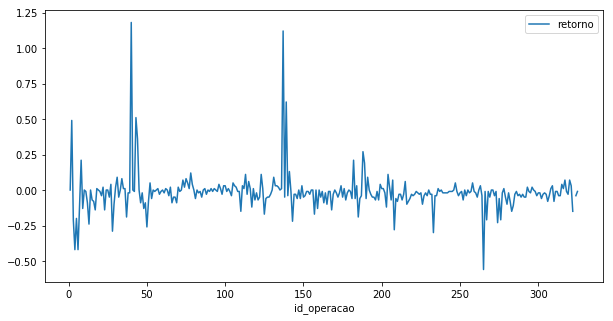

In [116]:
plt.figure()
resultado_operacoes[resultado_operacoes.type == 'buy'].plot(y='retorno',x='id_operacao',figsize=(10,5))

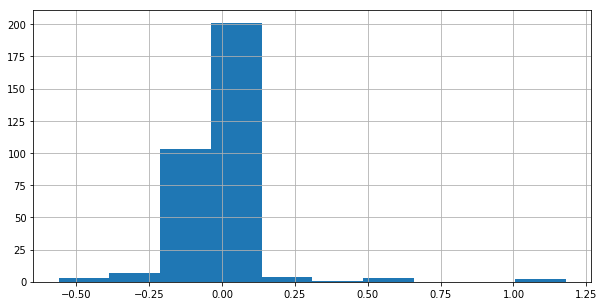

In [117]:
resultado_operacoes[resultado_operacoes.type == 'buy'].retorno.hist(figsize=(10,5))